# 2 - Models and Training
In this notebook we show how to load the dataset, load the different models (both learned and model based as a TF-graph), and train the models on the dataset.

In [35]:
import os

# because of the large (sparse) matrices, the gpu memory can get maxed out pretty quickly, resulting in errors like: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.
# to prevent this, you can disable/enable gpu completely by (un)commenting the following line
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


from src.config.config import DatasetConfig, ModelConfig, Config, TrainingConfig
from src.data.load import load_datasets
from src.models.training import train_from_config
from src.models.load import load_model
import matplotlib.pyplot as plt

from src.visualisation.visualise import plot_poloidal



## Load dataset and visualise sample

In [2]:
# define data configurations
data_config = DatasetConfig(shot_no=65903, batch_size=1)

# load datasets
train_ds, val_ds, test_ds = load_datasets(data_config)

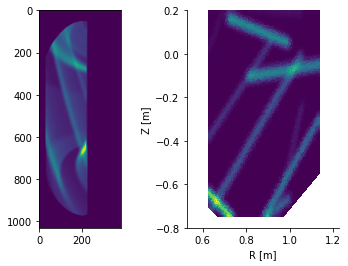

In [3]:
sample_image, sample_inversion = train_ds.__iter__().next()

input_shape = (sample_image.shape[1], sample_image.shape[2])
output_shape = (sample_inversion.shape[1], sample_inversion.shape[2])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(sample_image[0])
plot_poloidal(sample_inversion, axs[1])

## Load model architectures (model-based)

In [4]:
sirt_model_config = ModelConfig(name="sirt", shot_no=65903, n_iterations=100, mu=2.)
gd_model_config = ModelConfig(name="gradient descent", shot_no=65903, n_iterations=100, mu=0.034)

sirt_model_config.set_shape_from_ds(train_ds)
gd_model_config.set_shape_from_ds(train_ds)

In [5]:
sirt_model = load_model(sirt_model_config)
sirt_model.compile(metrics=['mse', 'mae'])

In [6]:
gd_model = load_model(gd_model_config)
gd_model.compile(metrics=['mse', 'mae'])

In [7]:
sirt_inversion_est = sirt_model(sample_image)
gd_inversion_est = gd_model(sample_image)

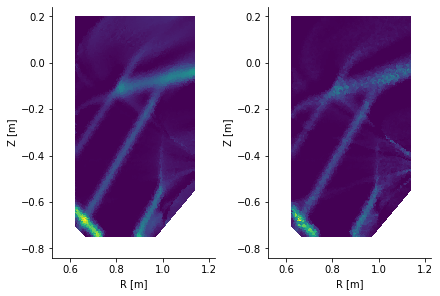

In [8]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)
plot_poloidal(sirt_inversion_est, axs[0])
plot_poloidal(gd_inversion_est, axs[1])

## Load model architectures (learned)

In [9]:
unet_sirt_informed_config = ModelConfig(name="unet sirt", shot_no=65903)
unet_sirt_informed_config.set_shape_from_ds(train_ds)

unet_sirt_informed = load_model(unet_sirt_informed_config)
unet_sirt_informed.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

unet_sirt_informed.fit(train_ds.take(10))

10/10 [==============================] - 17s 1s/step - loss: 0.3126 - mse: 0.3126 - mae: 0.3042


In [13]:
learned_proximal_sirt_config = ModelConfig(name="unfolded proximal sirt", shot_no=65903, n_iterations=5, encoder_filters=[8, 8, 16, 32], decoder_filters=[32, 16, 8, 8], bottleneck_filters=[32])
learned_proximal_sirt_config.set_shape_from_ds(train_ds)

learned_proximal_sirt = load_model(learned_proximal_sirt_config)
learned_proximal_sirt.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

learned_proximal_sirt.fit(train_ds.take(10))

10/10 [==============================] - 40s 2s/step - loss: 0.1453 - mse: 0.1453 - mae: 0.1528


## Single config and train function

In [33]:
training_config = TrainingConfig(epochs=1)
config = Config(dataset=data_config, model=unet_sirt_informed_config, training=training_config)

In [ ]:
train_from_config(config)